In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/animals10/raw-img"

In [ ]:
img_size = (160,160)
batch_size = 32

train_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Save class names
class_names = train_data.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))

Found 17270 files belonging to 10 classes.
Using 13816 files for training.
Found 17270 files belonging to 10 classes.
Using 3454 files for validation.
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Number of classes: 10


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(AUTOTUNE)
val_data = val_data.prefetch(AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(160,160,3)
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(160,160,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 3155s 7s/step - accuracy: 0.8072 - loss: 0.6127 - val_accuracy: 0.9256 - val_loss: 0.2316
Epoch 2/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 62s 145ms/step - accuracy: 0.9318 - loss: 0.2198 - val_accuracy: 0.9378 - val_loss: 0.2060
Epoch 3/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 62s 144ms/step - accuracy: 0.9391 - loss: 0.1830 - val_accuracy: 0.9380 - val_loss: 0.2029
Epoch 4/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 62s 144ms/step - accuracy: 0.9446 - loss: 0.1623 - val_accuracy: 0.9380 - val_loss: 0.2210
Epoch 5/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 62s 145ms/step - accuracy: 0.9514 - loss: 0.1408 - val_accuracy: 0.9404 - val_loss: 0.2134


In [ ]:
base_model.trainable = True

# Freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 105s 192ms/step - accuracy: 0.8347 - loss: 0.5948 - val_accuracy: 0.9366 - val_loss: 0.2289
Epoch 2/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 64s 148ms/step - accuracy: 0.9136 - loss: 0.2626 - val_accuracy: 0.9415 - val_loss: 0.2078
Epoch 3/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - accuracy: 0.9335 - loss: 0.2067 - val_accuracy: 0.9450 - val_loss: 0.1992
Epoch 4/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 64s 148ms/step - accuracy: 0.9436 - loss: 0.1717 - val_accuracy: 0.9453 - val_loss: 0.1883
Epoch 5/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 64s 148ms/step - accuracy: 0.9525 - loss: 0.1360 - val_accuracy: 0.9467 - val_loss: 0.1865


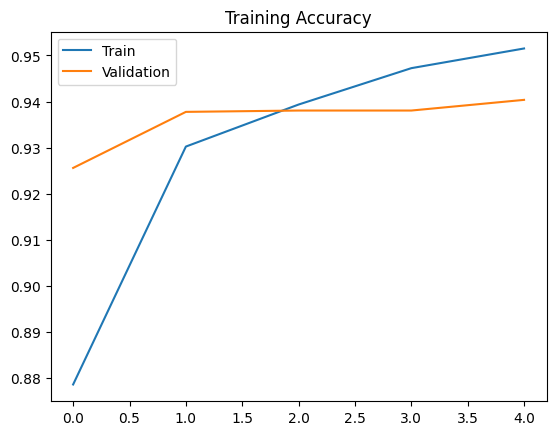

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Training Accuracy")
plt.legend(["Train","Validation"])
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/animal_transfer_model.keras")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving e83cb00a2ef1053ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg to e83cb00a2ef1053ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg


In [ ]:
img_path = list(uploaded.keys())[0]

img = tf.keras.utils.load_img(img_path, target_size=(160,160))
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

class_index = np.argmax(prediction)
confidence = np.max(prediction)

print("Predicted class:", class_names[class_index])
print("Confidence:", confidence * 100, "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted class: cane
Confidence: 86.071335 %


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving OIP-_1Zlq8IuJjORr6HhIGetCQHaFj.jpeg to OIP-_1Zlq8IuJjORr6HhIGetCQHaFj.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


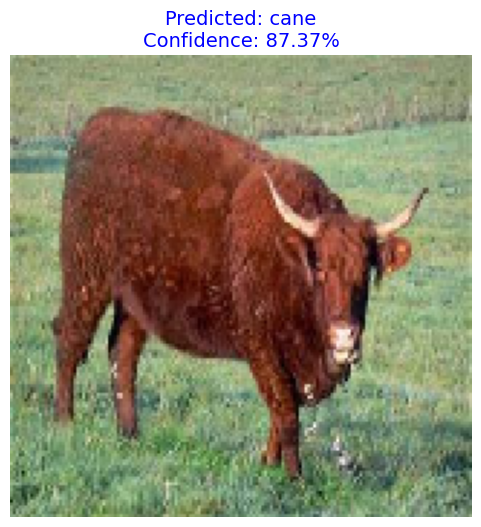

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load image
img_path = list(uploaded.keys())[0]   # change if needed
img = tf.keras.utils.load_img(img_path, target_size=(160,160))
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
class_index = np.argmax(prediction)
confidence = np.max(prediction)

predicted_class = class_names[class_index]

# 🔥 Visualization
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%",
          fontsize=14, color="blue")
plt.show()

In [ ]:
prediction = model.predict(img_array)

class_index = np.argmax(prediction)
confidence = np.max(prediction)

predicted_class = class_names[class_index]   # ← THIS LINE WAS MISSING

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


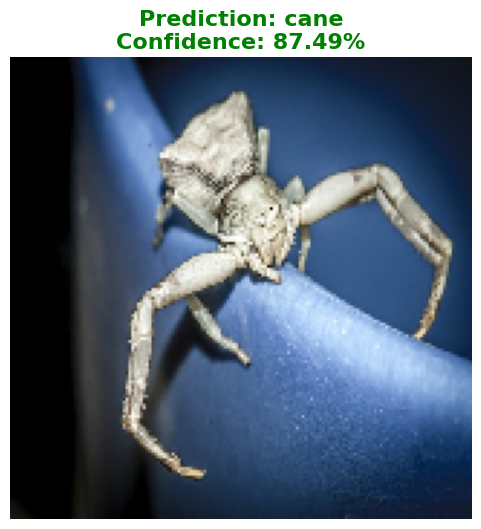

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
prediction = model.predict(img_array)
class_index = np.argmax(prediction)
confidence = np.max(prediction)

predicted_class = class_names[class_index]

# Choose color
color = "green" if confidence > 0.7 else "red"

# Plot
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")

plt.title(
    f"Prediction: {predicted_class}\nConfidence: {confidence*100:.2f}%",
    fontsize=16,
    color=color,
    fontweight="bold"
)

plt.show()